In [14]:
import os
import sys

import meep.adjoint as mpa
import numpy as np
from autograd import grad
from autograd import numpy as npa
from autograd import tensor_jacobian_product
from matplotlib import pyplot as plt
from matplotlib.patches import Circle
from scipy import signal, special
import math
import meep as mp
import nlopt  # need install nlopt

In [15]:
######################## Basic simulation ############################
np.random.seed(2000)
# if True compute flux (Gaussian source), if False compute DFT (Continue source)
compute_flux = True
# size of input and output waveguide
w = 0.5
h = 0.2

# resolution size
grid = 0.02
resolution = 1 / grid

# thickness of PML
dpml = 1

# length parameter
input_wvg_length = 5
output_wvg_length = 5
# design_region
design_region_x = 5
design_region_y = 0.2
sx = input_wvg_length + design_region_x + output_wvg_length + 2 * dpml

# height parameter
Substrate_thickness = 0.5
BOX_thickness = 2
TOX_thickness = 0.7
near_field_height = 1
sy = BOX_thickness + TOX_thickness + Substrate_thickness + near_field_height + 2 * dpml

cell = mp.Vector3(sx, sy, 0)

# Material setting
Si = mp.Medium(index=3.45)
SiO2 = mp.Medium(index=1.44)
SiN = mp.Medium(index=1.96)

# geometry
Substrate_geo = mp.Block(
    material=Si,
    center=mp.Vector3(y=-0.5 * sy + 0.5 * Substrate_thickness + dpml),
    size=mp.Vector3(sx, Substrate_thickness),
)
BOX_geo = mp.Block(
    material=SiO2,
    center=mp.Vector3(y=-0.5 * sy + Substrate_thickness + 0.5 * BOX_thickness + dpml),
    size=mp.Vector3(sx, BOX_thickness),
)
TOX_geo = mp.Block(
    material=SiO2,
    center=mp.Vector3(
        y=-0.5 * sy + Substrate_thickness + BOX_thickness + 0.5 * TOX_thickness + dpml
    ),
    size=mp.Vector3(sx, TOX_thickness),
)
input_waveguide_geo = mp.Block(
    material=SiN,
    center=mp.Vector3(
        -0.5 * sx + 0.5 * input_wvg_length + dpml,
        -0.5 * sy + Substrate_thickness + BOX_thickness + 0.5 * h + dpml,
    ),
    size=mp.Vector3(input_wvg_length, h),
)
output_waveguide_geo = mp.Block(
    material=SiN,
    center=mp.Vector3(
        0.5 * sx - 0.5 * output_wvg_length - dpml,
        -0.5 * sy + Substrate_thickness + BOX_thickness + 0.5 * h + dpml,
    ),
    size=mp.Vector3(output_wvg_length, h),
)

geometry = [
    Substrate_geo,
    BOX_geo,
    TOX_geo,
    input_waveguide_geo,
    output_waveguide_geo,
]

# design region
minimum_length = 0.05  # minimum length scale (microns)
eta_i = (
    0.5  # blueprint (or intermediate) design field thresholding point (between 0 and 1)
)
eta_e = 0.55  # erosion design field thresholding point (between 0 and 1)
eta_d = 1 - eta_e  # dilation design field thresholding point (between 0 and 1)
filter_radius = mpa.get_conic_radius_from_eta_e(minimum_length, eta_e)

design_region_resolution_x = int(resolution)
design_region_resolution_y = 5  # 200nm resolution
Nx = int(design_region_resolution_x * design_region_x)
Ny = int(design_region_resolution_y * design_region_y)
# 结构对称
# design_variables = mp.MaterialGrid(mp.Vector3(Nx, Ny), SiO2, SiN, grid_type="U_MEAN")
design_variables = mp.MaterialGrid(mp.Vector3(Nx, Ny), SiO2, SiN, grid_type="U_DEFAULT")
design_region = mpa.DesignRegion(
    design_variables,
    volume=mp.Volume(
        center=mp.Vector3(
            -0.5 * sx + input_wvg_length + 0.5 * design_region_x + dpml,
            -0.5 * sy + Substrate_thickness + BOX_thickness + 0.5 * h + dpml,
            0,
        ),
        size=mp.Vector3(design_region_x, design_region_y),
    ),
)
geometry.append(
    mp.Block(
        center=design_region.center,
        size=design_region.size,
        material=design_variables,
    )
)

# Sources
wvl = 0.785
fcen = 1 / wvl
fwidth = 0.2 * fcen
kpoint = mp.Vector3(1, 0, 0)

sources = [
    mp.EigenModeSource(
        mp.GaussianSource(frequency=fcen, fwidth=fwidth),
        center=input_waveguide_geo.center,
        size=mp.Vector3(0, 3 * h),
        eig_band=1,
        eig_parity=mp.EVEN_Y + mp.ODD_Z,
        eig_match_freq=True,
        direction=mp.NO_DIRECTION,
        eig_kpoint=kpoint,
    )
]
# set nomrlized source: amplitude is 1 -> flux is 1
sources[0].amplitude = 1 / mp.GaussianSource(fcen, fwidth=fwidth).fourier_transform(
    fcen
)

# Simulation
# 当EigenmodeSource设置eig_parity时(线性偏振)，且设置目标函数为mpa.EigenmodeCoefficient时，
# 必须设置force_all_components=True，否则在adjoint模式下中无法计算
# 见 #2309 https://github.com/NanoComp/meep/issues/2309
sim = mp.Simulation(
    resolution=resolution,
    cell_size=cell,
    boundary_layers=[mp.PML(dpml)],
    sources=sources,
    geometry=geometry,
    force_all_components=True,
)


######################## Basic simulation ############################

In [ ]:
###################### full angle point #####################
# # near_field points
# d_angle = 1  # !angle resolution
# ff_distance = 1e6  # far field distance
# ff_angle = 89  # !far field angle range
# ff_number = int(2 / d_angle * ff_angle) + 1  # !far field number
# ff_angles = np.linspace(-ff_angle, ff_angle, ff_number)  # far field angle list
# ff_points = [
#     mp.Vector3(fx, 1e6, 0) for fx in np.tan(np.radians(ff_angles)) * ff_distance
# ]  # far field points list

# # near field region
# NearRegion = [
#     mp.Near2FarRegion(
#         center=mp.Vector3(0, 0.5 * sy - dpml - 0.5 * near_field_height, 0),
#         size=mp.Vector3(sx - 2 * dpml, 0),
#         weight=+1,
#     )
# ]

# # ff_points = [mp.Vector3(0, 1e6, 0)]
# # angle_index
# angle_index = np.where(ff_angles == 0)[0][0]

# # ob_list
# ob_list = [mpa.Near2FarFields(sim, NearRegion, [ff_point]) for ff_point in ff_points]

     block, center = (0,-1.85,0)
          size (17,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (11.9025,11.9025,11.9025)
     block, center = (0,-0.6,0)
          size (17,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.0736,2.0736,2.0736)
     block, center = (0,0.75,0)
          size (17,0.7,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.0736,2.0736,2.0736)
     block, center = (-5,0.5,0)
          size (5,0.2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.8416,3.8416,3.8416)
     block, center = (5,0.5,0)
          size (5,0.2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.8416,3.8416,3.8416)
     block

, center = (0,0.5,0)
          size (5,0.2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 0.000421047 s
Working in 2D dimensions.
Computational cell is 17 x 6.2 x 0 with resolution 50
     block, center = (0,-1.85,0)
          size (17,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (11.9025,11.9025,11.9025)
     block, center = (0,-0.6,0)
          size (17,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.0736,2.0736,2.0736)
     block, center = (0,0.75,0)
          size (17,0.7,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.0736,2.0736,2.0736)
     block, center = (-5,0.5,0)
          size (5,0.2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.8416,3.8416,3.8416)
     block, center = (5,0.5,0)
         

MPB solved for frequency_1(1,0,0) = 0.607781 after 8 iters
MPB solved for frequency_1(2.12376,0,0) = 1.2419 after 8 iters
MPB solved for frequency_1(2.1834,0,0) = 1.27381 after 6 iters
MPB solved for frequency_1(2.18354,0,0) = 1.27389 after 3 iters
MPB solved for frequency_1(2.18354,0,0) = 1.27389 after 1 iters
on time step 1205 (time=12.05), 0.00332134 s/step
on time step 2396 (time=23.96), 0.00336136 s/step
on time step 3599 (time=35.99), 0.00332652 s/step
on time step 4838 (time=48.38), 0.00322956 s/step
on time step 6079 (time=60.79), 0.0032237 s/step
on time step 7263 (time=72.63), 0.00338037 s/step
on time step 8480 (time=84.8), 0.00328844 s/step
on time step 9726 (time=97.26), 0.00321149 s/step
on time step 10980 (time=109.8), 0.00319216 s/step
on time step 12235 (time=122.35), 0.00318981 s/step


run 0 finished at t = 131.15 (13115 timesteps)
MPB solved for frequency_1(1.27389,0,0) = 0.768369 after 17 iters
MPB solved for frequency_1(2.14612,0,0) = 1.25388 after 8 iters
MPB solved for frequency_1(2.18349,0,0) = 1.27386 after 5 iters
MPB solved for frequency_1(2.18354,0,0) = 1.27389 after 3 iters
MPB solved for frequency_1(2.18354,0,0) = 1.27389 after 1 iters
Dominant planewave for band 1: (2.183544,-0.000000,0.000000)
Starting adjoint run...


MPB solved for frequency_1(-1.27389,0,0) = 0.768369 after 17 iters
MPB solved for frequency_1(-2.14612,0,0) = 1.25388 after 8 iters
MPB solved for frequency_1(-2.18349,0,0) = 1.27386 after 5 iters
MPB solved for frequency_1(-2.18354,0,0) = 1.27389 after 3 iters
MPB solved for frequency_1(-2.18354,0,0) = 1.27389 after 1 iters
on time step 1231 (time=12.31), 0.00325115 s/step
on time step 2487 (time=24.87), 0.00318691 s/step
on time step 3734 (time=37.34), 0.00320827 s/step
on time step 4979 (time=49.79), 0.00321466 s/step
on time step 6229 (time=62.29), 0.00320127 s/step
on time step 7477 (time=74.77), 0.00320643 s/step
on time step 8732 (time=87.32), 0.00318951 s/step
on time step 9961 (time=99.61), 0.00325505 s/step
on time step 11210 (time=112.1), 0.00320456 s/step
on time step 12461 (time=124.61), 0.0031976 s/step
on time step 13709 (time=137.09), 0.00320685 s/step
on time step 14958 (time=149.58), 0.00320489 s/step
run 1 finished at t = 154.85 (15485 timesteps)
Calculating gradient

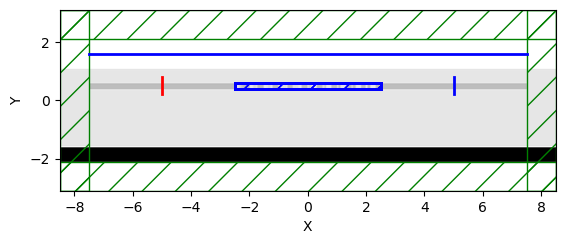

In [16]:
######################## Opt settings ############################
# 输出波导的flux
mode = 1
output_field = mp.Volume(
    center=output_waveguide_geo.center, size=mp.Vector3(0, 3 * h, 0)
)
out = mpa.EigenmodeCoefficient(sim, output_field, mode)
idea_output = 0.6

# near field region
NearRegion = [
    mp.Near2FarRegion(
        center=mp.Vector3(0, 0.5 * sy - dpml - 0.5 * near_field_height, 0),
        size=mp.Vector3(sx - 2 * dpml, 0),
        weight=+1,
    )
]

ff_points = [mp.Vector3(0, 1e6, 0)]

# ob_list
# point |E|^2: (3-8 e-6)
ob_list = [mpa.Near2FarFields(sim, NearRegion, ff_points), out]


#! return scalar obj not vector
# def J1(*FF):
#     points = []
#     # 将FF中每一个的点的Ez值取出来存入points中
#     # FF [list] FF[0][0, 0, 2] = point[0, 0, 2]
#     # point.size -> [1, 1, 6] -> ['Ex', 'Ey', 'Ez', 'Hx', 'Hy', 'Hz']
#     for point in FF:
#         points.append(point[0, 0, 2])
#     return (npa.abs(points[angle_index]) ** 2) / npa.sum(npa.abs(points) ** 2)


def J1(angle_point, out):
    # ob1为角度最大的目标函数，单目标优化的目标值在0.3左右
    out = np.squeeze(out)
    weight1 = np.power(10, 5)
    ob1 = (npa.abs(angle_point[0, 0, 2]) ** 2) * weight1
    # ob2为输出波导的目标函数，目标优化值在-0.1左右
    weight2 = 1
    ob2 = -npa.abs((npa.abs(out) ** 2 - idea_output) * weight2)
    ob = ob1 + ob2
    return ob


opt = mpa.OptimizationProblem(
    simulation=sim,
    objective_functions=[J1],
    objective_arguments=ob_list,
    design_regions=[design_region],
    frequencies=[fcen],
    decay_by=1e-5,
)

# define the initial design and confirm the optimization problem
number_para = Nx * Ny

# 初始化granting coupler为垂直耦合的eps
# 将 [1.44, 1.96] 的 eps 映射到 [0, 1] 之间
init_para = (
    np.abs(np.load("final_eps_seg_test_2.npy")[0:number_para, 5]) - 1.44**2
) / (1.96**2 - 1.44**2)

init_para[init_para < 0] = 0
init_para[init_para > 1] = 1

# 随机初始化
# init_para = np.random.random(number_para)
opt.update_design([init_para[0:number_para]])
opt.plot2D(True)

f, _ = opt([init_para[0:number_para]])

In [17]:
f

-0.07972744879045607

In [ ]:
# save evalution_history and eps
np.save("eval_history_negative_3.npy", evaluation_history)

eps = opt.sim.get_array(
    component=mp.Dielectric,
    frequency=fcen,
    center=mp.Vector3(
        -0.5 * sx + dpml + input_wvg_length + 0.5 * design_region_x,
        -0.5 * sy + Substrate_thickness + BOX_thickness + 0.5 * h + dpml,
        0,
    ),
    size=mp.Vector3(design_region_x, h, 0),
)
np.save("final_eps_negative_3.npy", eps)